In [42]:
!pip install -q transformers librosa wandb
!git clone https://github.com/Rudrabha/Wav2Lip.git 2>/dev/null || true
!mkdir -p Wav2Lip/checkpoints

!wget -q -nc "https://huggingface.co/Nekochu/Wav2Lip/resolve/main/wav2lip.pth" -O Wav2Lip/checkpoints/wav2lip.pth
!wget -q -nc "https://huggingface.co/Nekochu/Wav2Lip/resolve/main/lipsync_expert.pth" -O Wav2Lip/checkpoints/lipsync_expert.pth
!ls -lh Wav2Lip/checkpoints/*.pth

-rw-r--r-- 1 root root 189M Feb 16 02:27 Wav2Lip/checkpoints/lipsync_expert.pth
-rw-r--r-- 1 root root 416M Feb 16 02:27 Wav2Lip/checkpoints/wav2lip.pth


In [43]:
import sys
sys.path.insert(0, "/content")
sys.path.insert(0, "/content/Wav2Lip")

import gc
import json
import warnings
from pathlib import Path

import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import wandb
from torch.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from emotion_utils import (
    CrossModalEmotionLoss,
    DifferentiableVideoPreprocess,
    EmotionAgreementMetric,
    load_frozen_audio_encoder,
    load_frozen_video_encoder,
    extract_audio_embedding,
    extract_video_embedding,
)
from models.wav2lip import Wav2Lip as Wav2LipModel

warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
METADATA = "/content/processed_data/metadata.json"
WAV2LIP_CKPT = "/content/Wav2Lip/checkpoints/wav2lip.pth"
BEST_AUDIO_PATH = "/content/trained_encoders_v2/w2v2-lg-lr2e5"
BEST_VIDEO_PATH = "/content/trained_encoders_v2/tsf-lr3e5-16f-nf"
OUT_DIR = Path("/content/wav2lip_finetuned")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EXCLUDE = {0, 1, 3, 5, 7}
REMAP = {2: 0, 4: 1, 6: 2}
EMOTIONS = ["happy", "angry", "disgust"]

print(f"Device: {DEVICE}")

Device: cuda


In [44]:
IMG_SIZE = 96
MEL_STEP = 16
SR = 16000
FPS = 25

def wav_to_mel(wav_path, sr=SR):
    y, _ = librosa.load(wav_path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=80, hop_length=200, win_length=800,
        fmin=55, fmax=7600)
    return librosa.power_to_db(mel, ref=np.max).astype(np.float32)


class Wav2LipDataset(Dataset):
    def __init__(self, metadata_path, split, T=5):
        with open(metadata_path) as f:
            data = json.load(f)
        self.samples = [s for s in data
                        if s["split"] == split and s["emotion_idx"] not in EXCLUDE]
        self.T = T

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        wav, sr = torchaudio.load(s["audio_path"])
        audio_1d = wav.squeeze(0)

        mel = wav_to_mel(s["audio_path"])

        frames = np.load(s["frames_path"]).astype(np.float32) / 255.0
        n_frames = frames.shape[0]

        start = np.random.randint(0, max(1, n_frames - self.T))
        face_window = frames[start:start + self.T]
        if face_window.shape[0] < self.T:
            pad = np.repeat(face_window[-1:], self.T - face_window.shape[0], axis=0)
            face_window = np.concatenate([face_window, pad], axis=0)

        mel_start = int(start / FPS * SR / 200)
        mel_end = mel_start + MEL_STEP * self.T
        mel_window = mel[:, mel_start:mel_end]
        if mel_window.shape[1] < MEL_STEP * self.T:
            mel_window = np.pad(mel_window, ((0, 0), (0, MEL_STEP * self.T - mel_window.shape[1])))

        gt = torch.from_numpy(face_window).permute(0, 3, 1, 2)
        H, W = gt.shape[2], gt.shape[3]
        if H != IMG_SIZE or W != IMG_SIZE:
            gt = F.interpolate(gt, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)

        masked = gt.clone()
        masked[:, :, IMG_SIZE // 2:, :] = 0.0

        ref_idx = np.random.randint(0, n_frames)
        ref = torch.from_numpy(frames[ref_idx]).permute(2, 0, 1).unsqueeze(0).expand(self.T, -1, -1, -1)
        if ref.shape[2] != IMG_SIZE or ref.shape[3] != IMG_SIZE:
            ref = F.interpolate(ref, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)

        face_input = torch.cat([ref, masked], dim=1)

        mel_chunks = []
        for t in range(self.T):
            m = mel_window[:, t * MEL_STEP:(t + 1) * MEL_STEP]
            mel_chunks.append(torch.from_numpy(m).unsqueeze(0))
        mel_tensor = torch.stack(mel_chunks, dim=0)

        return {
            "mel": mel_tensor,
            "face_input": face_input,
            "gt": gt,
            "audio": audio_1d,
            "emotion": REMAP[s["emotion_idx"]],
        }


def collate_wav2lip(batch):
    return {
        "mel": torch.stack([b["mel"] for b in batch]),
        "face_input": torch.stack([b["face_input"] for b in batch]),
        "gt": torch.stack([b["gt"] for b in batch]),
        "audio": [b["audio"] for b in batch],
        "emotion": torch.tensor([b["emotion"] for b in batch]),
    }

In [45]:
def load_wav2lip(ckpt_path, device):
    model = Wav2LipModel()
    ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
    state = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
    state = {k.replace("module.", ""): v for k, v in state.items()}
    model.load_state_dict(state, strict=False)
    return model.to(device)

wav2lip = load_wav2lip(WAV2LIP_CKPT, DEVICE)
print(f"Wav2Lip loaded: {sum(p.numel() for p in wav2lip.parameters()) / 1e6:.1f}M params")

audio_enc, audio_proc = load_frozen_audio_encoder(BEST_AUDIO_PATH, DEVICE)
video_enc = load_frozen_video_encoder(BEST_VIDEO_PATH, DEVICE)
video_preprocess = DifferentiableVideoPreprocess(224).to(DEVICE)

VIDEO_ENC_FRAMES = getattr(video_enc.config, "num_frames", 8)
AUDIO_DIM = audio_enc.config.hidden_size
VIDEO_DIM = video_enc.config.hidden_size
PROJ_DIM = 256
print(f"Frozen encoders loaded. Video: {VIDEO_ENC_FRAMES} frames. "
      f"Audio dim={AUDIO_DIM}, Video dim={VIDEO_DIM}, Proj dim={PROJ_DIM}")

Wav2Lip loaded: 36.3M params
Frozen encoders loaded. Video: 8 frames. Audio dim=1024, Video dim=768, Proj dim=256


In [46]:
wandb.login()

CONFIGS = [
    {"name": "wav2lip-baseline", "lambda_emo": 0.0},
    {"name": "wav2lip-emo-001",  "lambda_emo": 0.01},
    {"name": "wav2lip-emo-005",  "lambda_emo": 0.05},
    {"name": "wav2lip-emo-01",   "lambda_emo": 0.1},
]

LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 4
PATIENCE = 5
T_FRAMES = 5

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [47]:
def adapt_frames(frames, target_t):
    """Resample (B, T, C, H, W) to (B, target_t, C, H, W) via uniform index sampling."""
    B, T, C, H, W = frames.shape
    if T == target_t:
        return frames
    idx = torch.linspace(0, T - 1, target_t).long()
    return frames[:, idx]


def train_one_epoch(model, loader, optimizer, scaler, emotion_loss_fn, lambda_emo):
    model.train()
    total_recon, total_emo, total_loss = 0.0, 0.0, 0.0

    for batch in tqdm(loader, leave=False):
        mel = batch["mel"].to(DEVICE)
        face_in = batch["face_input"].to(DEVICE)
        gt = batch["gt"].to(DEVICE)
        B, T = mel.shape[0], mel.shape[1]

        optimizer.zero_grad(set_to_none=True)

        all_gen = []
        recon = 0.0
        with autocast("cuda", enabled=DEVICE == "cuda"):
            for t in range(T):
                gen = model(mel[:, t], face_in[:, t])
                recon += F.l1_loss(gen, gt[:, t])
                all_gen.append(gen)
            recon = recon / T

            emo = torch.tensor(0.0, device=DEVICE)
            if lambda_emo > 0:
                gen_video = torch.stack(all_gen, dim=1)
                gen_video = adapt_frames(gen_video, VIDEO_ENC_FRAMES)
                audio_emb = extract_audio_embedding(
                    audio_enc, audio_proc, batch["audio"], device=DEVICE)
                video_emb = extract_video_embedding(
                    video_enc, video_preprocess, gen_video, device=DEVICE)
                emo = emotion_loss_fn(audio_proj(audio_emb.detach()),
                                      video_proj(video_emb))

            loss = recon + lambda_emo * emo

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_recon += recon.item()
        total_emo += emo.item()
        total_loss += loss.item()

    n = len(loader)
    return {"recon": total_recon / n, "emotion": total_emo / n, "total": total_loss / n}


@torch.no_grad()
def evaluate(model, loader, emotion_loss_fn, lambda_emo):
    model.eval()
    total_recon, total_emo, total_loss = 0.0, 0.0, 0.0
    metric = EmotionAgreementMetric()

    for batch in tqdm(loader, leave=False):
        mel = batch["mel"].to(DEVICE)
        face_in = batch["face_input"].to(DEVICE)
        gt = batch["gt"].to(DEVICE)
        B, T = mel.shape[0], mel.shape[1]

        all_gen = []
        recon = 0.0
        with autocast("cuda", enabled=DEVICE == "cuda"):
            for t in range(T):
                gen = model(mel[:, t], face_in[:, t])
                recon += F.l1_loss(gen, gt[:, t])
                all_gen.append(gen)
            recon = recon / T

            emo = torch.tensor(0.0, device=DEVICE)
            if lambda_emo > 0:
                gen_video = torch.stack(all_gen, dim=1)
                gen_video = adapt_frames(gen_video, VIDEO_ENC_FRAMES)
                audio_emb = extract_audio_embedding(
                    audio_enc, audio_proc, batch["audio"], device=DEVICE)
                video_emb = extract_video_embedding(
                    video_enc, video_preprocess, gen_video, device=DEVICE)
                a_p, v_p = audio_proj(audio_emb), video_proj(video_emb)
                emo = emotion_loss_fn(a_p, v_p)
                metric.update(a_p, v_p)

            loss = recon + lambda_emo * emo

        total_recon += recon.item()
        total_emo += emo.item()
        total_loss += loss.item()

    n = len(loader)
    result = {"recon": total_recon / n, "emotion": total_emo / n, "total": total_loss / n}
    if lambda_emo > 0:
        result.update(metric.compute())
    return result

In [48]:
train_ds = Wav2LipDataset(METADATA, "train", T=T_FRAMES)
val_ds = Wav2LipDataset(METADATA, "val", T=T_FRAMES)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, collate_fn=collate_wav2lip)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=0, collate_fn=collate_wav2lip)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

all_results = []

for cfg in CONFIGS:
    name = cfg["name"]
    lambda_emo = cfg["lambda_emo"]
    print(f"\n{'='*60}\n{name} (lambda_emo={lambda_emo})\n{'='*60}")

    wandb.init(project="uncanny-valley-wav2lip", name=name,
               config={**cfg, "lr": LR, "epochs": EPOCHS}, reinit=True)

    model = load_wav2lip(WAV2LIP_CKPT, DEVICE)
    audio_proj = nn.Linear(AUDIO_DIM, PROJ_DIM, bias=False).to(DEVICE)
    video_proj = nn.Linear(VIDEO_DIM, PROJ_DIM, bias=False).to(DEVICE)
    params = list(model.parameters())
    if lambda_emo > 0:
        params += list(audio_proj.parameters()) + list(video_proj.parameters())
    optimizer = torch.optim.AdamW(params, lr=LR)
    scaler = GradScaler(enabled=DEVICE == "cuda")
    emotion_loss_fn = CrossModalEmotionLoss(weight=1.0)

    best_val, patience_cnt = float("inf"), 0
    save_path = OUT_DIR / name

    for epoch in range(EPOCHS):
        t = train_one_epoch(model, train_loader, optimizer, scaler,
                            emotion_loss_fn, lambda_emo)
        v = evaluate(model, val_loader, emotion_loss_fn, lambda_emo)

        wandb.log({
            "epoch": epoch + 1,
            "train/recon": t["recon"], "train/emotion": t["emotion"], "train/total": t["total"],
            "val/recon": v["recon"], "val/emotion": v["emotion"], "val/total": v["total"],
            **{f"val/{k}": v[k] for k in ["avg_cosine_sim", "agreement_rate"] if k in v},
        })

        print(f"  [{epoch+1:2d}/{EPOCHS}] "
              f"t_loss={t['total']:.4f} v_loss={v['total']:.4f} v_recon={v['recon']:.4f}"
              + (f" cos_sim={v.get('avg_cosine_sim', 0):.3f}" if lambda_emo > 0 else ""))

        if v["total"] < best_val:
            best_val = v["total"]
            save_path.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), save_path / "wav2lip.pth")
            torch.save({"audio_proj": audio_proj.state_dict(),
                         "video_proj": video_proj.state_dict()},
                        save_path / "projections.pth")
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= PATIENCE:
                print(f"  Early stopping at epoch {epoch+1}")
                break

    wandb.finish()
    del model, optimizer, scaler, audio_proj, video_proj
    torch.cuda.empty_cache()
    gc.collect()
    all_results.append({"name": name, "lambda_emo": lambda_emo, "best_val": best_val})
    print(f"  Best val loss: {best_val:.4f} -> {save_path}")

Train: 408, Val: 72

wav2lip-baseline (lambda_emo=0.0)


  [ 1/20] t_loss=0.3554 v_loss=0.2947 v_recon=0.2947


  [ 2/20] t_loss=0.2695 v_loss=0.2390 v_recon=0.2390


  [ 3/20] t_loss=0.2162 v_loss=0.1924 v_recon=0.1924


  [ 4/20] t_loss=0.1854 v_loss=0.1680 v_recon=0.1680


  [ 5/20] t_loss=0.1505 v_loss=0.1374 v_recon=0.1374


  [ 6/20] t_loss=0.1255 v_loss=0.1210 v_recon=0.1210


  [ 7/20] t_loss=0.1119 v_loss=0.1091 v_recon=0.1091


  [ 8/20] t_loss=0.1051 v_loss=0.0974 v_recon=0.0974


  [ 9/20] t_loss=0.0941 v_loss=0.0895 v_recon=0.0895


  [10/20] t_loss=0.0873 v_loss=0.0829 v_recon=0.0829


  [11/20] t_loss=0.0840 v_loss=0.0788 v_recon=0.0788


  [12/20] t_loss=0.0757 v_loss=0.0694 v_recon=0.0694


  [13/20] t_loss=0.0687 v_loss=0.0673 v_recon=0.0673


  [14/20] t_loss=0.0643 v_loss=0.0669 v_recon=0.0669


  [15/20] t_loss=0.0604 v_loss=0.0677 v_recon=0.0677


  [16/20] t_loss=0.0571 v_loss=0.0555 v_recon=0.0555


  [17/20] t_loss=0.0538 v_loss=0.0581 v_recon=0.0581


  [18/20] t_loss=0.0513 v_loss=0.0506 v_recon=0.0506


  [19/20] t_loss=0.0493 v_loss=0.0502 v_recon=0.0502


  [20/20] t_loss=0.0477 v_loss=0.0533 v_recon=0.0533


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/emotion,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/total,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val/emotion,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/recon,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/total,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train/emotion,0
train/recon,0.04765
train/total,0.04765


  Best val loss: 0.0502 -> /content/wav2lip_finetuned/wav2lip-baseline

wav2lip-emo-001 (lambda_emo=0.01)


  [ 1/20] t_loss=0.3581 v_loss=0.3065 v_recon=0.3049 cos_sim=0.837


  [ 2/20] t_loss=0.2695 v_loss=0.2310 v_recon=0.2295 cos_sim=0.845


  [ 3/20] t_loss=0.2197 v_loss=0.2044 v_recon=0.2029 cos_sim=0.848


  [ 4/20] t_loss=0.1870 v_loss=0.1819 v_recon=0.1804 cos_sim=0.850


  [ 5/20] t_loss=0.1521 v_loss=0.1485 v_recon=0.1470 cos_sim=0.852


  [ 6/20] t_loss=0.1274 v_loss=0.1217 v_recon=0.1202 cos_sim=0.853


  [ 7/20] t_loss=0.1136 v_loss=0.1108 v_recon=0.1094 cos_sim=0.853


  [ 8/20] t_loss=0.1018 v_loss=0.0988 v_recon=0.0973 cos_sim=0.854


  [ 9/20] t_loss=0.0947 v_loss=0.1003 v_recon=0.0989 cos_sim=0.854


  [10/20] t_loss=0.0875 v_loss=0.0843 v_recon=0.0828 cos_sim=0.854


  [11/20] t_loss=0.0812 v_loss=0.0845 v_recon=0.0831 cos_sim=0.853


  [12/20] t_loss=0.0754 v_loss=0.0762 v_recon=0.0748 cos_sim=0.853


  [13/20] t_loss=0.0696 v_loss=0.0728 v_recon=0.0713 cos_sim=0.853


  [14/20] t_loss=0.0645 v_loss=0.0653 v_recon=0.0638 cos_sim=0.852


  [15/20] t_loss=0.0603 v_loss=0.0602 v_recon=0.0587 cos_sim=0.852


  [16/20] t_loss=0.0574 v_loss=0.0647 v_recon=0.0632 cos_sim=0.852


  [17/20] t_loss=0.0550 v_loss=0.0557 v_recon=0.0542 cos_sim=0.851


  [18/20] t_loss=0.0522 v_loss=0.0519 v_recon=0.0504 cos_sim=0.851


  [19/20] t_loss=0.0502 v_loss=0.0546 v_recon=0.0531 cos_sim=0.850


  [20/20] t_loss=0.0476 v_loss=0.0501 v_recon=0.0486 cos_sim=0.850


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/emotion,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/total,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val/agreement_rate,▁▅▅█████████████████
val/avg_cosine_sim,▁▄▆▆▇███████▇▇▇▇▇▇▇▆
val/emotion,█▅▃▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃
val/recon,█▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/total,█▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train/emotion,0.00087


  Best val loss: 0.0501 -> /content/wav2lip_finetuned/wav2lip-emo-001

wav2lip-emo-005 (lambda_emo=0.05)


  [ 1/20] t_loss=0.3701 v_loss=0.3289 v_recon=0.3208 cos_sim=0.837


  [ 2/20] t_loss=0.2760 v_loss=0.2468 v_recon=0.2391 cos_sim=0.846


  [ 3/20] t_loss=0.2236 v_loss=0.2092 v_recon=0.2017 cos_sim=0.850


  [ 4/20] t_loss=0.1886 v_loss=0.1851 v_recon=0.1777 cos_sim=0.851


  [ 5/20] t_loss=0.1563 v_loss=0.1402 v_recon=0.1328 cos_sim=0.853


  [ 6/20] t_loss=0.1283 v_loss=0.1298 v_recon=0.1224 cos_sim=0.853


  [ 7/20] t_loss=0.1133 v_loss=0.1164 v_recon=0.1090 cos_sim=0.853


  [ 8/20] t_loss=0.1045 v_loss=0.1040 v_recon=0.0967 cos_sim=0.853


  [ 9/20] t_loss=0.0958 v_loss=0.1008 v_recon=0.0934 cos_sim=0.853


  [10/20] t_loss=0.0887 v_loss=0.0957 v_recon=0.0884 cos_sim=0.853


  [11/20] t_loss=0.0830 v_loss=0.0883 v_recon=0.0809 cos_sim=0.853


  [12/20] t_loss=0.0757 v_loss=0.0796 v_recon=0.0722 cos_sim=0.853


  [13/20] t_loss=0.0691 v_loss=0.0899 v_recon=0.0825 cos_sim=0.851


  [14/20] t_loss=0.0657 v_loss=0.0698 v_recon=0.0624 cos_sim=0.852


  [15/20] t_loss=0.0605 v_loss=0.0731 v_recon=0.0656 cos_sim=0.851


  [16/20] t_loss=0.0579 v_loss=0.0644 v_recon=0.0570 cos_sim=0.851


  [17/20] t_loss=0.0547 v_loss=0.0625 v_recon=0.0550 cos_sim=0.851


  [18/20] t_loss=0.0531 v_loss=0.0609 v_recon=0.0534 cos_sim=0.850


  [19/20] t_loss=0.0505 v_loss=0.0565 v_recon=0.0490 cos_sim=0.850


  [20/20] t_loss=0.0480 v_loss=0.0589 v_recon=0.0513 cos_sim=0.849


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/emotion,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/total,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val/agreement_rate,▁▅██████████████████
val/avg_cosine_sim,▁▅▇▇████████▇▇▇▇▇▇▆▆
val/emotion,█▄▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃
val/recon,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val/total,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train/emotion,0.00084


  Best val loss: 0.0565 -> /content/wav2lip_finetuned/wav2lip-emo-005

wav2lip-emo-01 (lambda_emo=0.1)


  [ 1/20] t_loss=0.3776 v_loss=0.3404 v_recon=0.3242 cos_sim=0.838


  [ 2/20] t_loss=0.2831 v_loss=0.2645 v_recon=0.2491 cos_sim=0.847


  [ 3/20] t_loss=0.2290 v_loss=0.2171 v_recon=0.2023 cos_sim=0.851


  [ 4/20] t_loss=0.1927 v_loss=0.1901 v_recon=0.1756 cos_sim=0.855


  [ 5/20] t_loss=0.1601 v_loss=0.1637 v_recon=0.1492 cos_sim=0.855


  [ 6/20] t_loss=0.1307 v_loss=0.1341 v_recon=0.1196 cos_sim=0.855


  [ 7/20] t_loss=0.1153 v_loss=0.1234 v_recon=0.1090 cos_sim=0.856


  [ 8/20] t_loss=0.1054 v_loss=0.1184 v_recon=0.1040 cos_sim=0.856


  [ 9/20] t_loss=0.0972 v_loss=0.1074 v_recon=0.0929 cos_sim=0.855


  [10/20] t_loss=0.0900 v_loss=0.1000 v_recon=0.0856 cos_sim=0.855


  [11/20] t_loss=0.0833 v_loss=0.1021 v_recon=0.0875 cos_sim=0.855


  [12/20] t_loss=0.0772 v_loss=0.0897 v_recon=0.0751 cos_sim=0.854


  [13/20] t_loss=0.0691 v_loss=0.0832 v_recon=0.0685 cos_sim=0.854


  [14/20] t_loss=0.0666 v_loss=0.0810 v_recon=0.0664 cos_sim=0.854


  [15/20] t_loss=0.0612 v_loss=0.0744 v_recon=0.0597 cos_sim=0.853


  [16/20] t_loss=0.0600 v_loss=0.0733 v_recon=0.0586 cos_sim=0.853


  [17/20] t_loss=0.0565 v_loss=0.0746 v_recon=0.0598 cos_sim=0.852


  [18/20] t_loss=0.0527 v_loss=0.0654 v_recon=0.0505 cos_sim=0.852


  [19/20] t_loss=0.0505 v_loss=0.0673 v_recon=0.0524 cos_sim=0.851


  [20/20] t_loss=0.0507 v_loss=0.0648 v_recon=0.0499 cos_sim=0.851


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/emotion,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/recon,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/total,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val/agreement_rate,▁▆▆█████████████████
val/avg_cosine_sim,▁▄▆▇██████▇▇▇▇▇▇▆▆▆▆
val/emotion,█▅▃▂▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃
val/recon,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val/total,█▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
train/emotion,0.0009


  Best val loss: 0.0648 -> /content/wav2lip_finetuned/wav2lip-emo-01


            name  lambda_emo  best_val
 wav2lip-emo-001        0.01  0.050129
wav2lip-baseline        0.00  0.050228
 wav2lip-emo-005        0.05  0.056458
  wav2lip-emo-01        0.10  0.064778


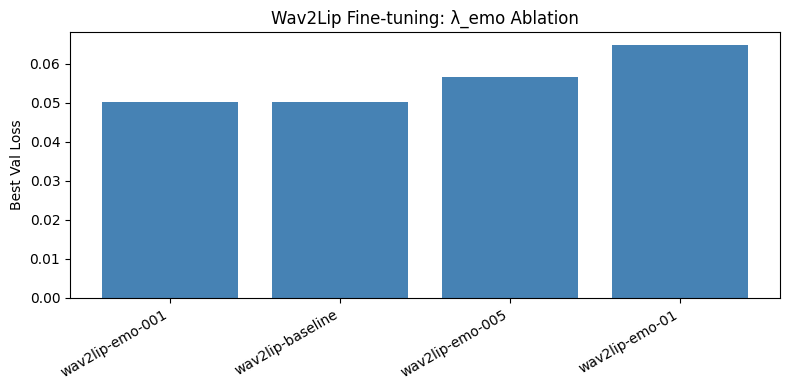

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(all_results).sort_values("best_val")
print(df.to_string(index=False))

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(df["name"], df["best_val"], color="steelblue")
ax.set_ylabel("Best Val Loss")
ax.set_title("Wav2Lip Fine-tuning: λ_emo Ablation")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [50]:
best_name = df.iloc[0]["name"]
best_model = load_wav2lip(WAV2LIP_CKPT, DEVICE)
best_model.load_state_dict(torch.load(OUT_DIR / best_name / "wav2lip.pth", map_location=DEVICE, weights_only=True))
best_model.eval()

audio_proj = nn.Linear(AUDIO_DIM, PROJ_DIM, bias=False).to(DEVICE)
video_proj = nn.Linear(VIDEO_DIM, PROJ_DIM, bias=False).to(DEVICE)
proj_ckpt = torch.load(OUT_DIR / best_name / "projections.pth", map_location=DEVICE, weights_only=True)
audio_proj.load_state_dict(proj_ckpt["audio_proj"])
video_proj.load_state_dict(proj_ckpt["video_proj"])
audio_proj.eval()
video_proj.eval()
print(f"Loaded best model: {best_name}")

metric = EmotionAgreementMetric()
all_recon = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating best"):
        mel = batch["mel"].to(DEVICE)
        face_in = batch["face_input"].to(DEVICE)
        gt = batch["gt"].to(DEVICE)
        T = mel.shape[1]

        all_gen = []
        for t in range(T):
            gen = best_model(mel[:, t], face_in[:, t])
            all_gen.append(gen)
            all_recon.append(F.l1_loss(gen, gt[:, t]).item())

        gen_video = torch.stack(all_gen, dim=1)
        gen_video = adapt_frames(gen_video, VIDEO_ENC_FRAMES)
        audio_emb = extract_audio_embedding(audio_enc, audio_proc, batch["audio"], device=DEVICE)
        video_emb = extract_video_embedding(video_enc, video_preprocess, gen_video, device=DEVICE)
        metric.update(audio_proj(audio_emb), video_proj(video_emb))

agreement = metric.compute()
print(f"\nBest model evaluation:")
print(f"  Avg L1 recon:     {np.mean(all_recon):.4f}")
print(f"  Avg cosine sim:   {agreement['avg_cosine_sim']:.4f}")
print(f"  Agreement rate:   {agreement['agreement_rate']:.4f}")
print(f"  Std cosine sim:   {agreement['std_cosine_sim']:.4f}")

del best_model
torch.cuda.empty_cache()

Loaded best model: wav2lip-emo-001


Evaluating best: 100%|██████████| 18/18 [00:08<00:00,  2.17it/s]


Best model evaluation:
  Avg L1 recon:     0.0480
  Avg cosine sim:   0.8504
  Agreement rate:   0.9028
  Std cosine sim:   0.4582
